# Определение перспективного тарифа для телеком-компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей
**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
*Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.*

In [1]:
import pandas as pd
from math import ceil
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

## Обзор и предобработка данных

### Набор данных о звонках

Общая информация о наборе данных:

In [3]:
display(calls.head())
calls.info()
calls.describe()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Необходимые правки:
1. Приведение поля call_date к типу данных `datetime`.
2. Округление продолжительности звонков в соответствие с тарифной сеткой оператора.
3. Присутствует незначимый в рамках проекта атрибут id. В рамках проекта данный атрибут здесь и далее будет исключаться из рассмотрения. 

Примечение об атрибуте id:

*В целом, если это так называемый суррогатный ключ таблицы, то оптимально было бы привести его к типу `integer`, так как текстовые поля тяжелее в обработке. Дополнительно стоит обратить внимание, что сама структура данного id довольно неоднозначная, так как атрибут выглядит вполне пригодным для, например, джоина на какую-либо другую таблицу из представленных в проекте, что на самом деле является в корне неверным действием, т.к., например, первое сообщение первого пользователя (id = 1000_1 совершенно не пересекается по смыслу с первым звонком (хотя id также равен 1000_1). То есть при сохранении типа данных id целесообразнее было бы отразить дополнительно принадлежность к виду коммуникации (например, 1000_1_1 для звонков, 1000_2_1 для смс и так далее)*

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['duration'] = np.ceil(calls['duration'])
calls.drop(columns=['id'], inplace=True)

In [5]:
display(calls.head())
calls.info()

,call_date,duration,user_id
0,2018-07-25,0.0,1000
1,2018-08-17,0.0,1000
2,2018-06-11,3.0,1000
3,2018-09-21,14.0,1000
4,2018-12-15,6.0,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   call_date  202607 non-null  datetime64[ns]
 1   duration   202607 non-null  float64       
 2   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 4.6 MB


**Вывод**: набор данных о звонках приведен к виду, достаточному для дальнейшей обработки и анализа.

### Набор данных об интернет-трафике

Общая информация о наборе данных:

In [6]:
display(internet.head())
internet.info()
internet.describe()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


Необходимые правки:
1. Приведение поля session_date к типу данных `datetime`.
2. На данном этапе будет корректно переопределить расчёт трафика в мегабайтах на гигабайты (без округления).
3. Присутствует безымянное поле, которое по своей сути является обычным индексом, а также незначимый атрибут id. Их нужно удалить.

In [7]:
internet['session_date'] = pd.to_datetime(internet['session_date'])
internet['gb_used'] = internet['mb_used'] / 1024.0
#internet.rename(columns={'mb_used':'gb_used'}, inplace=True)
internet.drop(columns=['Unnamed: 0', 'id'], inplace=True)

In [8]:
display(internet.head())
internet.info()

,mb_used,session_date,user_id,gb_used
0,112.95,2018-11-25,1000,0.110303
1,1052.81,2018-09-07,1000,1.028135
2,1197.26,2018-06-25,1000,1.169199
3,550.27,2018-08-22,1000,0.537373
4,302.56,2018-09-24,1000,0.295469


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   mb_used       149396 non-null  float64       
 1   session_date  149396 non-null  datetime64[ns]
 2   user_id       149396 non-null  int64         
 3   gb_used       149396 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.6 MB


**Вывод**: набор данных об интернет-трафике приведен к виду, достаточному для дальнейшей обработки и анализа.

### Набор данных о сообщениях

Общая информация о наборе данных:

In [9]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Необходимые правки:
1. Приведение поля message_date к типу данных `datetime`.
2. Присутствует незначимый атрибут id.

In [10]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages.drop(columns=['id'], inplace=True)

In [11]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   message_date  123036 non-null  datetime64[ns]
 1   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.9 MB


**Вывод**: набор данных о сообщениях приведен к виду, достаточному для дальнейшей обработки и анализа.

### Набор данных о тарифах

Общая информация о наборе данных:

In [12]:
display(tariffs.head())
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


**Вывод**: набор данных о тарифах полностью пригоден для дальнейшей обработки и анализа.

### Набор данных о пользователях

Общая информация о наборе данных:

In [13]:
display(users.head())
users.info()
users.describe()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Необходимые правки:

1. Приведение полей churn_date и reg_date к типу данных datetime.
2. Исключим из рассмотрения незначимые в рамках проекта атрибуты: first_name, last_name.

In [14]:
users['churn_date'] = pd.to_datetime(users['churn_date'])
users.drop(columns=['first_name', 'last_name'], inplace=True)

In [15]:
display(users.head())
users.info()

,user_id,age,churn_date,city,reg_date,tariff
0,1000,52,NaT,Краснодар,2018-05-25,ultra
1,1001,41,NaT,Москва,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,2018-06-17,smart
3,1003,23,NaT,Москва,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   reg_date    500 non-null    object        
 5   tariff      500 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 23.6+ KB


**Вывод**: набор данных о пользователях полностью пригоден для дальнейшей обработки и анализа.

## Подготовка данных и расчёт дохода

### Подготовка данных о звонках

In [16]:
calls['mth'] = calls['call_date'].dt.month
calls_per_month = (
    calls.groupby(['user_id', 'mth'])['duration'].
    agg(['count', 'sum']).
    reset_index().
    sort_values(by=['user_id', 'mth'])
)
calls_per_month.rename(columns={'count':'num_of_calls', 'sum':'sum_minutes'}, inplace=True)
calls_per_month.head()

,user_id,mth,num_of_calls,sum_minutes
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0


**Вывод**: данные о звонках подготовлены для дальнейшего анализа

### Подготовка данных о сообщениях

In [17]:
messages['mth'] = messages['message_date'].dt.month
messages_per_month = (
    messages.groupby(['user_id', 'mth']).
    count().
    reset_index().
    sort_values(by=['user_id', 'mth'])
)
messages_per_month.rename(columns={'message_date':'num_of_messages'}, inplace=True)
messages_per_month.head()

,user_id,mth,num_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


**Вывод**: данные о сообщениях подготовлены для дальнейшего анализа

### Подготовка данных об интернет-трафике

In [18]:
internet['mth'] = internet['session_date'].dt.month
internet_per_month = (
    internet.groupby(['user_id', 'mth']).
    sum('gb_used').
    reset_index().
    sort_values(by=['user_id', 'mth'])
)
internet_per_month.rename(columns={'message_date':'num_of_messages'}, inplace=True)
internet_per_month.head()

,user_id,mth,mb_used,gb_used
0,1000,5,2253.49,2.200674
1,1000,6,23233.77,22.689229
2,1000,7,14003.64,13.675430
3,1000,8,14055.93,13.726494
4,1000,9,14568.91,14.227451


**Вывод**: данные об интернет-трафике подготовлены для дальнейшего анализа

### Расчёт дохода

In [19]:
# подтягиваем информацию о тарифах
users_info = users.merge(tariffs, how='inner', left_on='tariff', right_on='tariff_name')

# формируем технический датафрейм
# в котором каждому пользователю будет соответствовать номер месяца от 1 до 12
tech_df = pd.DataFrame(
    {'user_id':[item for sublist in [[1000 + x] for x in range(len(users))]*12 for item in sublist], 
     'mth': [item for sublist in [[x]*len(users) for x in range(1,13)] for item in sublist]})

# расширяем таблицу пользователей месяцами
users_info = tech_df.merge(users_info, how='left', on='user_id')

# присоединяем информацию о звонках, сообщениях и интернет-трафике
users_info = users_info.merge(calls_per_month, how='left', on=['user_id', 'mth'])
users_info = users_info.merge(messages_per_month, how='left', on=['user_id', 'mth'])
users_info = users_info.merge(internet_per_month, how='left', on=['user_id', 'mth'])

# расчитываем всё, что сверх бесплатных минут/смс/трафика
users_info['extra_min'] = users_info['sum_minutes'] -  users_info['minutes_included']
users_info['extra_mes'] = users_info['num_of_messages'] -  users_info['messages_included']
users_info['extra_gb'] = np.ceil(users_info['gb_used'] -  users_info['mb_per_month_included'] / 1024.0)

# корректируем те записи, где не превышены включенные минуты/смс/гб
users_info.loc[users_info['extra_min'] < 0, 'extra_min'] = 0
users_info.loc[users_info['extra_mes'] < 0, 'extra_mes'] = 0
users_info.loc[users_info['extra_gb'] < 0, 'extra_gb'] = 0

# заполняем нулями везде, где посчитать не удалось
users_info['extra_min'].fillna(0, inplace=True)
users_info['extra_mes'].fillna(0, inplace=True)
users_info['extra_gb'].fillna(0, inplace=True)

# заполняем -1 везде, где нет информации о звонках/смс/трафике
users_info['num_of_calls'].fillna(-1, inplace=True)
users_info['sum_minutes'].fillna(-1, inplace=True)
users_info['num_of_messages'].fillna(-1, inplace=True)
users_info['gb_used'].fillna(-1, inplace=True)

# считаем выручку
users_info['revenue'] = (users_info['rub_monthly_fee'] + 
                         users_info['extra_min'] * users_info['rub_per_minute'] + 
                         users_info['extra_mes'] * users_info['rub_per_message'] + 
                         users_info['extra_gb'] * users_info['rub_per_gb'] )

# исключаем лишние записи для корректности стат.анализа
users_info.loc[
    (users_info['num_of_calls'] == -1) & 
    (users_info['sum_minutes'] == -1) &
    (users_info['num_of_messages'] == -1) &
    (users_info['gb_used'] == -1) &
    ((pd.to_datetime(users_info['reg_date']).dt.month > users_info['mth']) |
    (pd.to_datetime(users_info['churn_date']).dt.month < users_info['mth'])), 'drop_flg'] = 1
users_info.drop(users_info[users_info['drop_flg'] == 1].index, inplace=True)

display(users_info[ # для ознакомления, после проверки удалить
    (users_info['num_of_calls'] == -1) & 
    (users_info['sum_minutes'] == -1) &
    (users_info['num_of_messages'] == -1) &
    (users_info['gb_used'] == -1)
])
# исключаем лишние атрибуты
users_info.drop(columns=['messages_included', 'mb_per_month_included', 
                         'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 
                         'rub_per_minute', 'drop_flg', 'extra_min', 'extra_mes', 'extra_gb', 'tariff',
                         'churn_date', 'reg_date', 'mb_used'], inplace=True)

,user_id,mth,age,churn_date,city,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,...,num_of_calls,sum_minutes,num_of_messages,mb_used,gb_used,extra_min,extra_mes,extra_gb,revenue,drop_flg
5628,1128,12,51,2018-12-23,Волжский,2018-12-15,ultra,1000,30720,3000,...,-1.0,-1.0,-1.0,NaN,-1.0,0.0,0.0,0.0,1950.0,NaN
5871,1371,12,50,2018-12-30,Омск,2018-12-25,smart,50,15360,500,...,-1.0,-1.0,-1.0,NaN,-1.0,0.0,0.0,0.0,550.0,NaN


In [20]:
users_info.head(12)

,user_id,mth,age,city,tariff_name,num_of_calls,sum_minutes,num_of_messages,gb_used,revenue
5,1005,1,67,Набережные Челны,smart,15.0,95.0,7.0,2.664033,550.0
32,1032,1,31,Ульяновск,smart,61.0,380.0,38.0,23.562197,2350.0
45,1045,1,48,Улан-Удэ,smart,1.0,9.0,5.0,2.291709,550.0
55,1055,1,39,Казань,smart,64.0,551.0,30.0,16.690313,1103.0
71,1071,1,20,Омск,smart,24.0,194.0,16.0,15.238613,750.0
113,1113,1,52,Чита,smart,18.0,110.0,14.0,0.748262,550.0
120,1120,1,25,Краснодар,ultra,5.0,55.0,-1.0,0.641357,1950.0
126,1126,1,71,Санкт-Петербург,ultra,35.0,272.0,4.0,15.979521,1950.0
134,1134,1,65,Красноярск,smart,42.0,332.0,32.0,9.960947,550.0
135,1135,1,64,Архангельск,smart,9.0,90.0,1.0,1.562773,550.0


## Исследовательский анализ данных

### Подготовка данных

Подготовка необходимых выборок и назначение уровня значимости. В качестве уровня значимости установлено значение 0.05, т.к. значения меньше используются, как правило, в высокоточных исследованиях. В рамках текущей задачи необходимо определить общую тенденцию.

In [21]:
smart_users = users_info[users_info['tariff_name'] == 'smart']
ultra_users = users_info[users_info['tariff_name'] == 'ultra']
moscow = users_info[users_info['city'] == 'Москва']
region = users_info[users_info['city'] != 'Москва']
alpha = 0.05

Вспомогательные функции для сокращения кода:

In [22]:
def info_stat(smart, ultra, text):
    print(f'Медиана {text} для тарифа Smart:', smart.median())
    print(f'Среднее значение {text} для тарифа Smart:', smart.mean())
    print(f'Дисперсия {text} для тарифа Smart:', np.var(smart))
    print(f'Стандартное отклонение {text} для тарифа Smart:', np.std(smart))
    print('-----------')
    print(f'Медиана {text} для тарифа Ultra:', ultra.median())
    print(f'Среднее значение {text} для тарифа Ultra:', ultra.mean())
    print(f'Дисперсия {text} для тарифа Ultra:', np.var(ultra))
    print(f'Стандартное отклонение {text} для тарифа Ultra:', np.std(ultra))
    print('-----------')
    print(f'Процентная разница между средними:', round(np.abs((ultra.mean() /  smart.mean() - 1) * 100),2), '%')
def city_stat(moscow, region, text):
    print(f'Медиана {text} для Москвы:', moscow.median())
    print(f'Среднее значение {text} для Москвы:', moscow.mean())
    print(f'Дисперсия {text} для Москвы:', np.var(moscow))
    print(f'Стандартное отклонение {text} для Москвы:', np.std(moscow))
    print('-----------')
    print(f'Медиана {text} для остальных регионов:', region.median())
    print(f'Среднее значение {text} для остальных регионов:', region.mean())
    print(f'Дисперсия {text} для остальных регионов:', np.var(region))
    print(f'Стандартное отклонение {text} для остальных регионов:', np.std(region))
    print('-----------')
    print(f'Процентная разница между средними:', round(np.abs((moscow.mean() /  region.mean() - 1) * 100),2), '%')

### Исследование количества звонков

Здесь и далее будет использоваться статистический тест Стьюдента о равенстве средних двух генеральных совокупностей (t-test). 

#### Для пользователей разных тарифов

Медиана количества звонков для тарифа Smart: 60.0
Среднее значение количества звонков для тарифа Smart: 58.43408071748879
Дисперсия количества звонков для тарифа Smart: 674.1748026302561
Стандартное отклонение количества звонков для тарифа Smart: 25.96487632611132
-----------
Медиана количества звонков для тарифа Ultra: 73.5
Среднее значение количества звонков для тарифа Ultra: 73.28296146044624
Дисперсия количества звонков для тарифа Ultra: 1935.4746995461821
Стандартное отклонение количества звонков для тарифа Ultra: 43.9940302716878
-----------
Процентная разница между средними: 25.41 %


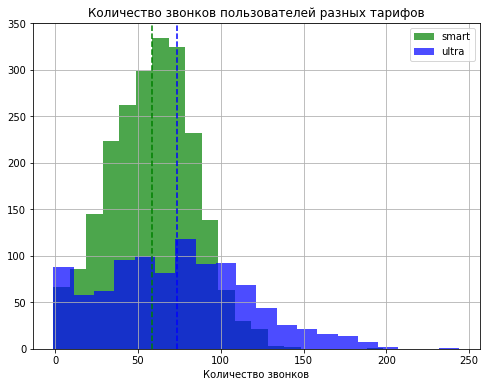

In [23]:
smart_users['num_of_calls'].hist(bins=20, alpha=0.7, label='smart', color='green', figsize=(8,6));
ultra_users['num_of_calls'].hist(bins=20, alpha=0.7, label='ultra', color='blue');
plt.axvline(smart_users['num_of_calls'].mean(), ls='--', color='green')
plt.axvline(ultra_users['num_of_calls'].mean(), ls='--', color='blue')
plt.title('Количество звонков пользователей разных тарифов');
plt.legend();
plt.xlabel('Количество звонков');
info_stat(smart_users['num_of_calls'], ultra_users['num_of_calls'], 'количества звонков')

In [24]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(smart_users['num_of_calls'], ultra_users['num_of_calls'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества звонков пользователей разных тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества звонков пользователей разных тарифов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 4.5396403386913284e-32
Отвергаем нулевую гипотезу о равенстве среднего количества звонков пользователей разных тарифов


**Вывод**: статистический тест о равенстве двух генеральных совокупностей показал, что гипотезу о равенстве можно отвергнуть, так как p-value существенно ниже установленного уровня значимости. Стоит обратить внимание, что на графике также заметно, что средние выборочные значения различаются довольно существенно. Таким образом можно заключить, что среднее количество звонков пользователей тарифа Ultra выше, чем количество звонков пользователей Smart.

#### Для пользователей из разных регионов

Медиана количества звонков для Москвы: 64.0
Среднее значение количества звонков для Москвы: 65.43535188216039
Дисперсия количества звонков для Москвы: 1099.7253623557206
Стандартное отклонение количества звонков для Москвы: 33.16210732682289
-----------
Медиана количества звонков для остальных регионов: 62.0
Среднее значение количества звонков для остальных регионов: 62.412284069097886
Дисперсия количества звонков для остальных регионов: 1107.9006552436808
Стандартное отклонение количества звонков для остальных регионов: 33.28514165875941
-----------
Процентная разница между средними: 4.84 %


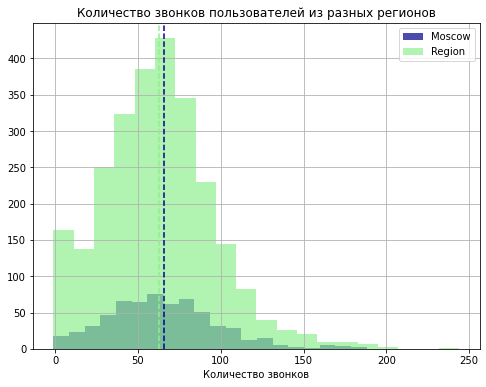

In [25]:
moscow['num_of_calls'].hist(bins=20, alpha=0.7, label='Moscow', color='darkblue', figsize=(8,6));
region['num_of_calls'].hist(bins=20, alpha=0.7, label='Region', color='lightgreen');
plt.axvline(moscow['num_of_calls'].mean(), ls='--', color='darkblue')
plt.axvline(region['num_of_calls'].mean(), ls='--', color='lightgreen')
plt.title('Количество звонков пользователей из разных регионов');
plt.legend();
plt.xlabel('Количество звонков');
city_stat(moscow['num_of_calls'], region['num_of_calls'], 'количества звонков')

In [26]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(moscow['num_of_calls'], region['num_of_calls'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества звонков пользователей из разных регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества звонков пользователей из разных регионов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 0.04333015023434035
Отвергаем нулевую гипотезу о равенстве среднего количества звонков пользователей из разных регионов


**Вывод**: статистический тест о равенстве двух генеральных совокупностей показал, что гипотезу о равенстве можно отвергнуть, так как p-value ниже установленного уровня значимости. Важно отметить, что установив уровень значимости несколько ниже, отвергнуть гипотезу о равенстве было бы уже нельзя. Однако, в рамках данного эксперимента можно заключить, что среднее количество звонков пользователей из Москвы выше, чем количество звонков пользователей из других регионов.

### Исследование потраченных минут

#### Для пользователей разных тарифов

Медиана расхода минут для тарифа Smart: 421.5
Среднее значение расхода минут для тарифа Smart: 417.74439461883406
Дисперсия расхода минут для тарифа Smart: 36267.74991252589
Стандартное отклонение расхода минут для тарифа Smart: 190.4409354958274
-----------
Медиана расхода минут для тарифа Ultra: 518.0
Среднее значение расхода минут для тарифа Ultra: 526.053752535497
Дисперсия расхода минут для тарифа Ultra: 100987.38960559394
Стандартное отклонение расхода минут для тарифа Ultra: 317.7851311902335
-----------
Процентная разница между средними: 25.93 %


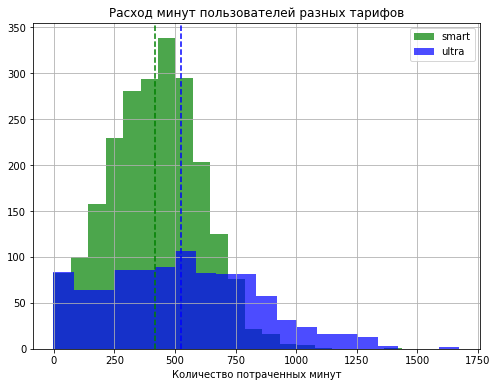

In [27]:
smart_users['sum_minutes'].hist(bins=20, alpha=0.7, label='smart', color='green', figsize=(8,6));
ultra_users['sum_minutes'].hist(bins=20, alpha=0.7, label='ultra', color='blue');
plt.axvline(smart_users['sum_minutes'].mean(), ls='--', color='green')
plt.axvline(ultra_users['sum_minutes'].mean(), ls='--', color='blue')
plt.title('Расход минут пользователей разных тарифов');
plt.legend();
plt.xlabel('Количество потраченных минут')
info_stat(smart_users['sum_minutes'], ultra_users['sum_minutes'], 'расхода минут')

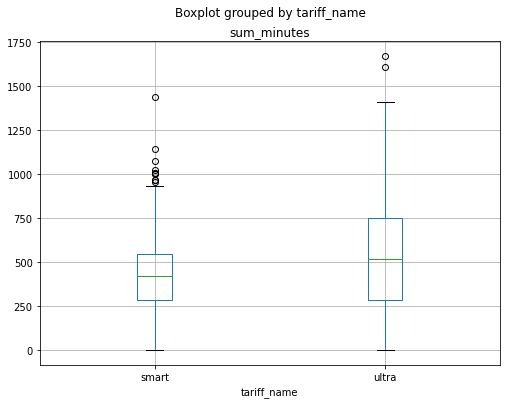

In [28]:
users_info.boxplot(column='sum_minutes', by='tariff_name', figsize=(8, 6));

In [29]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(smart_users['sum_minutes'], ultra_users['sum_minutes'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества потраченных минут пользователей разных тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества потраченных минут пользователей разных тарифов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 3.024704974776528e-32
Отвергаем нулевую гипотезу о равенстве среднего количества потраченных минут пользователей разных тарифов


**Вывод**: нулевая гипотеза вполне уверенно отвергается, на графике также видны существенные различия. Таким образом можно заключить, что пользователи тарифа Ultra расходуют больше минут, чем пользователи тарифа Smart.

#### Для пользователей из разных регионов

Медиана потраченных минут для Москвы: 453.0
Среднее значение потраченных минут для Москвы: 469.1489361702128
Дисперсия потраченных минут для Москвы: 58245.233137166135
Стандартное отклонение потраченных минут для Москвы: 241.34049212091645
-----------
Медиана потраченных минут для остальных регионов: 440.0
Среднее значение потраченных минут для остальных регионов: 446.68291746641074
Дисперсия потраченных минут для остальных регионов: 58592.4937005095
Стандартное отклонение потраченных минут для остальных регионов: 242.05886412298455
-----------
Процентная разница между средними: 5.03 %


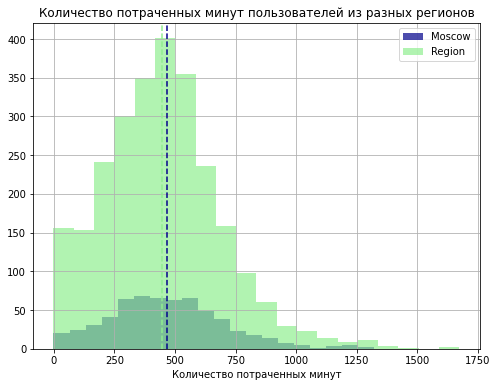

In [30]:
moscow['sum_minutes'].hist(bins=20, alpha=0.7, label='Moscow', color='darkblue', figsize=(8,6));
region['sum_minutes'].hist(bins=20, alpha=0.7, label='Region', color='lightgreen');
plt.axvline(moscow['sum_minutes'].mean(), ls='--', color='darkblue')
plt.axvline(region['sum_minutes'].mean(), ls='--', color='lightgreen')
plt.title('Количество потраченных минут пользователей из разных регионов');
plt.legend();
plt.xlabel('Количество потраченных минут')
city_stat(moscow['sum_minutes'], region['sum_minutes'], 'потраченных минут')

In [31]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(moscow['sum_minutes'], region['sum_minutes'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества потраченных минут пользователей из разных регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества потраченных минут пользователей из разных регионов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 0.03897553078713986
Отвергаем нулевую гипотезу о равенстве среднего количества потраченных минут пользователей из разных регионов


**Вывод**: как и в предыдущем эксперименте с количеством звонком мы отвергаем нулевую гипотезу, обращая внимание на то, что понижение значения уровня значимости приведет к тому, что нулевую гипотезу отвергнуть будет нельзя. В рамках эксперимента можно заключить, что пользователи тарифа Ultra расходуют больше минут, чем пользователи тарифа Smart.

### Исследование расхода интернет-трафика

#### Для пользователей разных тарифов

Медиана расхода интернет-трафика для тарифа Smart: 16.1186279296875
Среднее значение расхода интернет-трафика для тарифа Smart: 15.820508075252242
Дисперсия расхода интернет-трафика для тарифа Smart: 32.978096852053326
Стандартное отклонение расхода интернет-трафика для тарифа Smart: 5.742655905768108
-----------
Медиана расхода интернет-трафика для тарифа Ultra: 18.851582031249997
Среднее значение расхода интернет-трафика для тарифа Ultra: 18.982066439924573
Дисперсия расхода интернет-трафика для тарифа Ultra: 97.6415498770648
Стандартное отклонение расхода интернет-трафика для тарифа Ultra: 9.881373886108388
-----------
Процентная разница между средними: 19.98 %


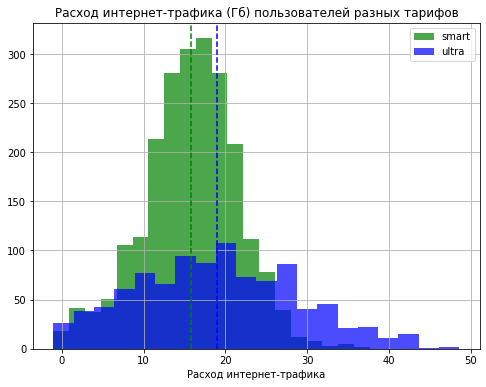

In [32]:
smart_users['gb_used'].hist(bins=20, alpha=0.7, label='smart', color='green', figsize=(8,6));
ultra_users['gb_used'].hist(bins=20, alpha=0.7, label='ultra', color='blue');
plt.axvline(smart_users['gb_used'].mean(), ls='--', color='green')
plt.axvline(ultra_users['gb_used'].mean(), ls='--', color='blue')
plt.title('Расход интернет-трафика (Гб) пользователей разных тарифов');
plt.legend();
plt.xlabel('Расход интернет-трафика')
info_stat(smart_users['gb_used'], ultra_users['gb_used'], 'расхода интернет-трафика')

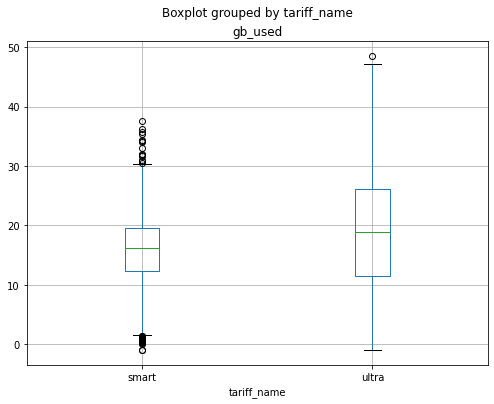

In [33]:
users_info.boxplot(column='gb_used', by='tariff_name', figsize=(8, 6));

In [34]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(smart_users['gb_used'], ultra_users['gb_used'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей разных тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей разных тарифов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 2.0686740692882061e-29
Отвергаем нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей разных тарифов


**Вывод**: в данном эксперименте также уверенно отвергается нулевая гипотеза. Интернет-трафик пользователи тарифа Ultra расходуют более активно, чем пользователи тарифа Smart.

#### Для пользователей из разных регионов

Медиана расхода интернет-трафика для Москвы: 17.126904296875
Среднее значение расхода интернет-трафика для Москвы: 17.5428452971563
Дисперсия расхода интернет-трафика для Москвы: 58.59639665043927
Стандартное отклонение расхода интернет-трафика для Москвы: 7.654828322728033
-----------
Медиана расхода интернет-трафика для остальных регионов: 16.454003906249998
Среднее значение расхода интернет-трафика для остальных регионов: 16.61319464146473
Дисперсия расхода интернет-трафика для остальных регионов: 53.90383325781595
Стандартное отклонение расхода интернет-трафика для остальных регионов: 7.341922994544137
-----------
Процентная разница между средними: 5.6 %


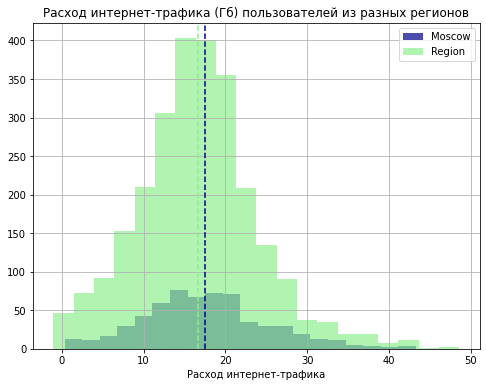

In [35]:
moscow['gb_used'].hist(bins=20, alpha=0.7, label='Moscow', color='darkblue', figsize=(8,6));
region['gb_used'].hist(bins=20, alpha=0.7, label='Region', color='lightgreen');
plt.axvline(moscow['gb_used'].mean(), ls='--', color='darkblue')
plt.axvline(region['gb_used'].mean(), ls='--', color='lightgreen')
plt.title('Расход интернет-трафика (Гб) пользователей из разных регионов');
plt.legend();
plt.xlabel('Расход интернет-трафика')
city_stat(moscow['gb_used'], region['gb_used'], 'расхода интернет-трафика')

In [36]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(moscow['gb_used'], region['gb_used'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей из разных регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей из разных регионов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 0.005252214208914043
Отвергаем нулевую гипотезу о равенстве среднего расхода интернет-трафика пользователей из разных регионов


**Вывод**: в данном эксперименте также нулевая гипотеза отвергается довольно уверенно. Москва расходует больше интернет-трафика, чем другие регионы.

### Исследование количества сообщений

#### Для пользователей разных тарифов

Медиана количества сообщений для тарифа Smart: 28.0
Среднее значение количества сообщений для тарифа Smart: 33.23094170403587
Дисперсия количества сообщений для тарифа Smart: 805.9345583060186
Стандартное отклонение количества сообщений для тарифа Smart: 28.388986567082995
-----------
Медиана количества сообщений для тарифа Ultra: 38.0
Среднее значение количества сообщений для тарифа Ultra: 49.11967545638945
Дисперсия количества сообщений для тарифа Ultra: 2302.360931334834
Стандартное отклонение количества сообщений для тарифа Ultra: 47.98292333043948
-----------
Процентная разница между средними: 47.81 %


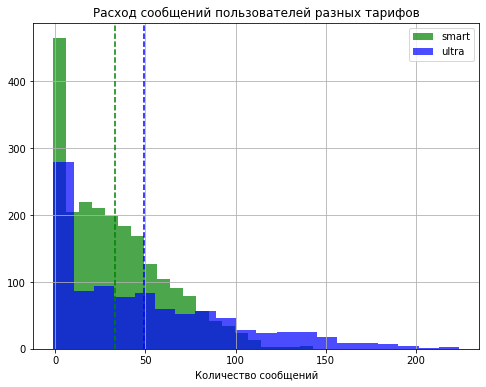

In [37]:
smart_users['num_of_messages'].hist(bins=20, alpha=0.7, label='smart', color='green', figsize=(8,6));
ultra_users['num_of_messages'].hist(bins=20, alpha=0.7, label='ultra', color='blue');
plt.axvline(smart_users['num_of_messages'].mean(), ls='--', color='green')
plt.axvline(ultra_users['num_of_messages'].mean(), ls='--', color='blue')
plt.title('Расход сообщений пользователей разных тарифов');
plt.xlabel('Количество сообщений')
plt.legend();
info_stat(smart_users['num_of_messages'], ultra_users['num_of_messages'], 'количества сообщений')

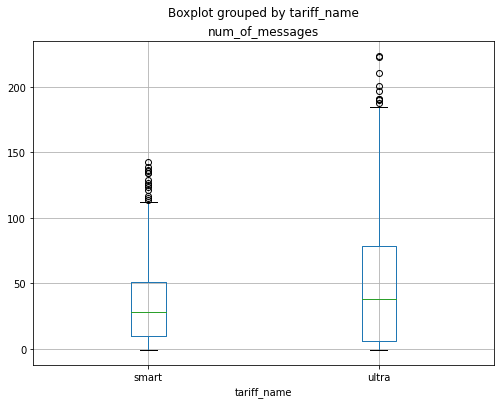

In [38]:
users_info.boxplot(column='num_of_messages', by='tariff_name', figsize=(8, 6));

In [39]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(smart_users['num_of_messages'], ultra_users['num_of_messages'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей разных тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей разных тарифов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 6.842605863222315e-31
Отвергаем нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей разных тарифов


**Вывод**: нулевая гипотеза уверенно отвергается. Количество отправленных сообщений у пользователей тарифа Ultra выше. При этом стоит обратит внимание, что довольно большое количество пользователей отправляет очень мало смс, либо вообще не отправляет.

#### Для пользователей из разных регионов

Медиана количества сообщений для Москвы: 29.0
Среднее значение количества сообщений для Москвы: 37.680851063829785
Дисперсия количества сообщений для Москвы: 1393.66410140335
Стандартное отклонение количества сообщений для Москвы: 37.33181085084609
-----------
Медиана количества сообщений для остальных регионов: 30.0
Среднее значение количества сообщений для остальных регионов: 38.20115163147793
Дисперсия количества сообщений для остальных регионов: 1300.6912078867967
Стандартное отклонение количества сообщений для остальных регионов: 36.06509680961354
-----------
Процентная разница между средними: 1.36 %


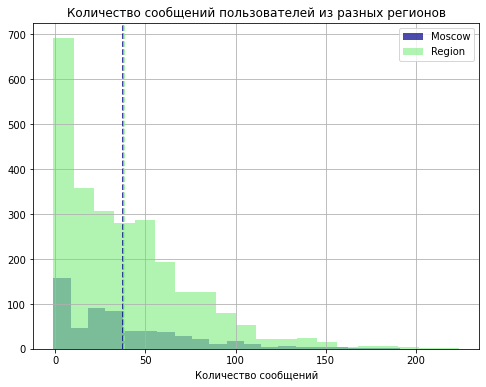

In [40]:
moscow['num_of_messages'].hist(bins=20, alpha=0.7, label='Moscow', color='darkblue', figsize=(8,6));
region['num_of_messages'].hist(bins=20, alpha=0.7, label='Region', color='lightgreen');
plt.axvline(moscow['num_of_messages'].mean(), ls='--', color='darkblue')
plt.axvline(region['num_of_messages'].mean(), ls='--', color='lightgreen')
plt.title('Количество сообщений пользователей из разных регионов');
plt.legend();
plt.xlabel('Количество сообщений')
city_stat(moscow['num_of_messages'], region['num_of_messages'], 'количества сообщений')

In [41]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(moscow['num_of_messages'], region['num_of_messages'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей из разных регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей из разных регионов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 0.7499817169096137
Не получилось отвергнуть нулевую гипотезу о равенстве среднего количества отправленных сообщений пользователей из разных регионов


**Вывод**: нулевую гипотезу отвергнуть не получилось, так как p-value существенно выше уровня значимости, а значит, что получить такое или еще более существенное различие довольно высокое при условии равенства средних двух генеральных совокупностей. Таким образом можно заключить, что жители Москвы и регионов отправляют примерно одинаковое количество сообщений.

### Исследование выручки

#### Для пользователей разных тарифов

Медиана выручки для тарифа Smart: 1021.0
Среднее значение выручки для тарифа Smart: 1289.6417040358745
Дисперсия выручки для тарифа Smart: 669430.4361979931
Стандартное отклонение выручки для тарифа Smart: 818.187286749185
-----------
Медиана выручки для тарифа Ultra: 1950.0
Среднее значение выручки для тарифа Ultra: 2070.030425963489
Дисперсия выручки для тарифа Ultra: 141244.31956107615
Стандартное отклонение выручки для тарифа Ultra: 375.8248522398115
-----------
Процентная разница между средними: 60.51 %


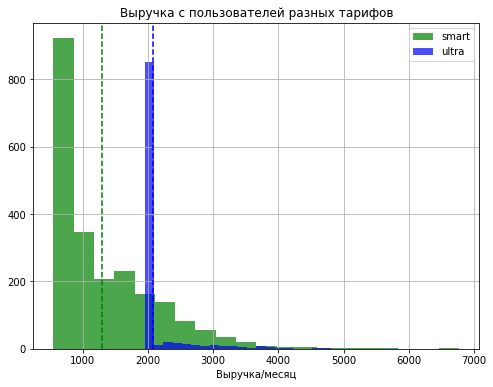

In [42]:
smart_users['revenue'].hist(bins=20, alpha=0.7, label='smart', color='green', figsize=(8,6));
ultra_users['revenue'].hist(bins=20, alpha=0.7, label='ultra', color='blue');
plt.axvline(smart_users['revenue'].mean(), ls='--', color='green')
plt.axvline(ultra_users['revenue'].mean(), ls='--', color='blue')
plt.title('Выручка с пользователей разных тарифов');
plt.legend();
plt.xlabel('Выручка/месяц')
info_stat(smart_users['revenue'], ultra_users['revenue'], 'выручки')

In [43]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(smart_users['revenue'], ultra_users['revenue'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве средней выручки пользователей разных тарифов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве средней выручки пользователей разных тарифов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 8.081909555489933e-161
Отвергаем нулевую гипотезу о равенстве средней выручки пользователей разных тарифов


**Вывод**: выручка пользователей двух тарифов статистически значимо различается. Пользователи тарифа Ultra приносят больше выручки, чем пользователи тарифа Smart. При этом стоит заметить, что пользователи тарифа Ultra редко превышают включенный в тариф бесплатный лимит, а пользователи тарифа Smart довольно часто.

#### Для пользователей из разных регионов

Медиана выручки для Москвы: 1750.0
Среднее значение выручки для Москвы: 1546.7135842880523
Дисперсия выручки для Москвы: 564710.7117467273
Стандартное отклонение выручки для Москвы: 751.4723625967407
-----------
Медиана выручки для остальных регионов: 1583.0
Среднее значение выручки для остальных регионов: 1524.7251439539348
Дисперсия выручки для остальных регионов: 653818.4925923496
Стандартное отклонение выручки для остальных регионов: 808.5904356300225
-----------
Процентная разница между средними: 1.44 %


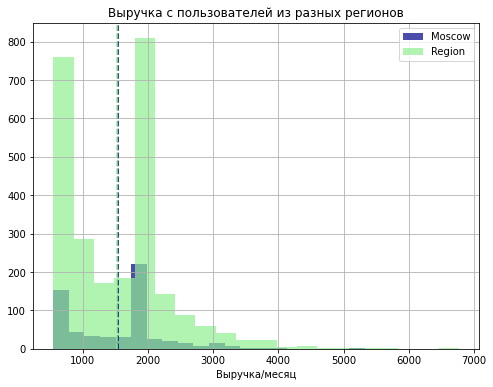

In [44]:
moscow['revenue'].hist(bins=20, alpha=0.7, label='Moscow', color='darkblue', figsize=(8,6));
region['revenue'].hist(bins=20, alpha=0.7, label='Region', color='lightgreen');
plt.axvline(moscow['revenue'].mean(), ls='--', color='darkblue')
plt.axvline(region['revenue'].mean(), ls='--', color='lightgreen')
plt.title('Выручка с пользователей из разных регионов');
plt.legend();
plt.xlabel('Выручка/месяц')
city_stat(moscow['revenue'], region['revenue'], 'выручки')

In [45]:
print('H0: средние двух генеральных совокупоностей равны')
print('H1: средние двух генеральных совокупоностей различаются')
ttest = st.ttest_ind(moscow['revenue'], region['revenue'])
print('p-значение:',ttest.pvalue)
if ttest.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу о равенстве средней выручки пользователей из разных регионов")
else:
    print("Не получилось отвергнуть нулевую гипотезу о равенстве средней выручки пользователей из разных регионов")

H0: средние двух генеральных совокупоностей равны
H1: средние двух генеральных совокупоностей различаются
p-значение: 0.5400751614511182
Не получилось отвергнуть нулевую гипотезу о равенстве средней выручки пользователей из разных регионов


**Вывод**: выручка с пользователей из Москвы и регионов статистически значимо не различается. Пиковые значения на графиках - это те пользователи, которые не превышают включенный лимит.

## Результаты исследования

В ходе исследования был проведен обзор данных, их предварительная обработка, а также проведены статистические тесты, результатами которых стали следующие результаты:

**В разрезе тарифа:**
* Количество звонков пользователей тарифа Ultra превышает количество звонков пользователей тарифа Smart на 25.4%.
* Количество израсходованных минут пользователей тарифа Ultra превышает количество израсходованных минут пользователей тарифа Smart на 25.9% .
* Количество израсходованного интернет-трафика пользователями тарифа Ultra превышает количество израсходованного интернет-трафика пользователями тарифа Smart на 19.9% .
* Количество отправленных сообщений пользователями тарифа Ultra превышает количество отправленных сообщений пользователями тарифа Smart на 47.8%.
* Пользователи тарифа Ultra приносят больше выручки, чем пользователи тарифа Smart на 60.5%.

**В разрезе региона:**
* Количество звонков пользователей из Москвы превышает количество звонков пользователей из других регионов на 4.8%.
* Количество израсходованных минут пользователей из Москвы превышает количество звонков пользователей из других регионов 5%.
* Количество израсходованного интернет-трафика пользователями из Москвы превышает количество израсходованного интернет-трафика пользователями из других регионов на 5.6%.
* Количество отправленных сообщений пользователями из Москвы статистически значимо не отличается от количества отправленных сообщений пользователями из других регионов.
* Пользователи из Москвы приносят такой же доход, как и пользователи из регионов.

**Заключение**: в целом, в результате эксперимента становится ясно, что тариф Ultra значительно выгоднее для оператора связи с точки зрения выручки, чем тариф Smart. При этом не установлено существенной разницы между пользователями Москвы и других регионов.